## Config BO

In [11]:
from langchain.prompts.prompt import PromptTemplate
initial_train = 1
ask_K = 1
N=20
M=5
model="curie"

In [ ]:
# I saved the number of samples in the training set in the pickle file. With that, old pickle weren't compatible with the new printing format.
# This script adds an array [0 .. len(samples)] to the old pickle files, so that they are compatible with the new printing format.

# import numpy as np
# import cloudpickle
# d = cloudpickle.load(open("./out/<OLD_FORMAT_BO>.pkl", "rb"))

# data = d
# for key, values in data.items():
#     num_aqs = values.shape[0]
#     num_entries = values.shape[1]
#     new_values = np.empty((num_aqs, num_entries, 3), dtype='<U349')
    
#     for j in range(num_aqs):
#         for i in range(num_entries):
#             description, value = values[j, i]
#             new_values[j, i] = [description, str(i+1), value]
#     data[key] = new_values

# cloudpickle.dump(data, open("./out/<NEW_FORMAT_BO>.pkl", "wb"))

### in-house

In [2]:
dataset="in-house"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="CO STY",
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7
)

path = f"./out/{dataset}_{model}_42000_{initial_train}_{ask_K}_16nr.pkl"
pool_path = "./dataset/data/42000_in-house_pool.pkl"


### OCM

In [12]:
dataset="ocm"
kwargs = dict(
    prefix="You are a bot who knows chemistry and catalysts. " \
            "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured C2 yield in a oxidative methane coupling reaction. " \
            "The following question should be answered with a number and finished with ###\n",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="C2 yield",
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7
)

path = f"./out/{dataset}_{model}_12744_{initial_train}_{ask_K}_16nr.pkl"
pool_path = "./dataset/data/12744_ocm_pool.pkl"


### Solubility

In [ ]:
dataset="sol"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"iupac name {x}",
    y_name="measured log solubility in mols per litre",
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7,
)

path = f"./out/{dataset}_{model}_882_{initial_train}_{ask_K}_16nr.pkl"
pool_path = "./out/sol_pool.pkl"


# Setup

In [13]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import bolift
from langchain.prompts.prompt import PromptTemplate
import copy, cloudpickle
import seaborn as sns

import os
from dotenv import load_dotenv
load_dotenv()

True

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random
np.random.seed(0)
random.seed(0)

## Utils

In [15]:
import uncertainty_toolbox as uct

def combine(s, l):
  '''Number of combinations of l elements with max = s'''
  return (s**l - (s-1)**(l))

def prob(s, l, n):
  '''Probability of getting a sample with max([x0,x1,...,xl]) = s where xi={0,n}'''
  return combine(s,l) * ((1/n)**l)

def expected_value_p(l, n):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  E = [s * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

def expected_value_q(l, n, data):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  quants = [data.quantile(i/100) for i in range(100+1)]
  # E = [(quants[s-1]) * prob(s, l, n) for s in range(1,100+1)]
  E = [((quants[s-1]+quants[s])/2) * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment(
    asktell, pool, raw_data, indexes, x_name, y_name, N=10, initial_train=1, ask_K=1, aq="random", start_index=0, calibrate=False
):
    if aq=='random_mean':
       return [ (i, expected_value_q(i, 100, raw_data[y_name])) for i in range(1,N+1) ]
    for i in indexes[:initial_train]:
        asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))
    if calibrate:
        # y = [float(raw_data[y_name].iloc[i]) for i in indexes[:initial_train]]
        # pred = asktell.predict(y)
        # ymeans = np.array([yhi.mean() for yhi in pred])
        # ystds = np.array([yhi.std() for yhi in pred])
        # calibration_factor = uct.recalibration.optimize_recalibration_ratio(ymeans, ystds, np.array(y), criterion="miscal")
        calibration_factor = 5.0
        asktell.set_calibration_factor(calibration_factor)

    x = raw_data[x_name].tolist()

    pool.reset()
    xi = x[start_index]
    x.remove(xi)
    pool.choose(xi)
    yi = float(raw_data[raw_data[x_name] == xi][y_name].iloc[0])
    asktell.tell(xi, yi)
    point = [(xi, 1+initial_train, yi, yi)]
    best = point[0][-1]
    for i in range(1, N):
        if i == N - 1 and aq != "random":
            aq = "greedy"
        px, _, py = asktell.ask(pool, 
                                k=ask_K, 
                                aq_fxn=aq, 
                                _lambda=1.0, 
                                inv_filter=16,
                                aug_random_filter=0,
                                )
        for j in range(ask_K):
          xc = px[j]
          x.remove(xc)
          pool.choose(xc)
          y = float(raw_data[raw_data[x_name] == xc][y_name].iloc[0])
          asktell.tell(xc, y)
          best = max(y, best)
        point.append((xc, 1+initial_train+i*ask_K, best, y))
    return point

In [16]:
def get_dataset(data: str, M=5):
    match data:
        case "in-house":
            data_path = "./dataset/data/71023_BO_ready_pool.csv"
            raw_data = pd.read_csv(data_path)

            raw_data['Catalyst'] = raw_data['Prompt'].str.extract(r'(\b[A-Z][a-z]?:[A-Z][a-z]?:[A-Z][a-z]?\b)')
            unique_cat = raw_data['Catalyst'].unique()
            c = {c: 0.2+m*(5/len(unique_cat)) for m, c in enumerate(unique_cat)}
            raw_data['dummy_Completion'] = raw_data['Catalyst'].apply(lambda x: np.random.normal(c[x], 0.05))

            x_name = "Prompt"
            y_name = "dummy_Completion"
        case "ocm":
            data_path = "./dataset/data/12744_ocm_dataset.csv"
            raw_data = pd.read_csv(data_path, sep=";")
            x_name = "prompt"
            y_name = "completion"
        case "sol":
            data_path = "./dataset/data/esol_iupac.csv"
            raw_data = pd.read_csv(data_path)
            raw_data = raw_data.dropna()
            raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
            x_name = "IUPAC"
            y_name = "measured log(solubility:mol/L)"
        case _:
            raise ValueError("Unknown data")
        
    N = raw_data.shape[0]
    indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)

    print(f"Dataset size: \n\t{N}")
    starts = raw_data.sort_values(by=y_name, ascending=True).head(100).sample(M)# np.random.randint(0, len(indexes), M)
    print(f"Start xs: \n\t{starts[x_name].to_list()}")
    print(f"Start ys: \n\t{starts[y_name].to_list()}")
    starts = starts.index
    print(f"Start indexes: \n\t{starts}\n")

    return raw_data, starts, indexes, x_name, y_name


In [17]:
def get_asktell(model: str, kwargs: dict = {}, pool: bolift.Pool = None, knn: int = 1):
    match model:
        case "instruct":
            kwargs['model']="gpt-3.5-turbo-instruct"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-turbo":
            kwargs['model']="gpt-3.5-turbo"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4":
            kwargs['model']="gpt-4"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "davinci":
            kwargs['model']="text-davinci-003"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "curie":
            kwargs['model']="text-curie-001"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpr":
            kwargs['selector_k'] = 0
            kwargs['pool'] = pool if pool else None
            kwargs['n_components'] = 32
            return bolift.AskTellGPR(**kwargs)
        # knn and krr don't output uncertainties
        # case "knn":
        #     del kwargs['selector_k']
        #     kwargs['knn'] = knn
        #     return bolift.AskTellNearestNeighbor(**kwargs)
        # case "krr":
        #     kwargs['alpha'] = 0.5
        #     return bolift.AskTellRidgeKernelRegression(**kwargs)
        case _:
            raise ValueError("Unknown model")

In [18]:
def read_bkp(path, pool_path, indexes, kwargs):
    if os.path.exists(pool_path):
        with open(pool_path, "rb") as f:
            pool = cloudpickle.load(f)
        pool.reset()
    else:
        x = [raw_data[x_name].iloc[i] for i in indexes]
        pool = bolift.Pool(list(x), formatter=kwargs['x_formatter'])
        cloudpickle.dump(pool, open(pool_path, "wb"))

    if os.path.exists(path):
        bayesOpts = cloudpickle.load(open(path, "rb"))
    else:
        bayesOpts = {}
    return bayesOpts, pool

# BayesOpt experiments

## Run BO

In [19]:
import warnings
warnings.filterwarnings('ignore', message='Changing the sparsity structure of a csr_matrix is expensive.*')
warnings.filterwarnings('ignore', message='Input data is not contained to the unit cube.*')
warnings.filterwarnings('ignore', message='Input data is not standardized.*')
warnings.filterwarnings('ignore', message="Keyword arguments .* will be ignored because they are not allowed parameters for function .*", category=UserWarning)

raw_data, starts, indexes, x_name, y_name = get_dataset(dataset, M=M)
bayesOpts, pool = read_bkp(path, pool_path, indexes, kwargs)

asktell = get_asktell(model, kwargs=kwargs)#, pool=bolift.Pool(list(pool.sample(5000))), knn=5)

Dataset size: 
	12708
Start xs: 
	['To synthesize BN, BN (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of n.a. (0%), n.a. (0%), n.a. (0%), at 50 ºC for 6 h. Once activated the reaction is ran at 700 ºC. The total flow rate was 10 mL/min (Ar: 7.0 mL/min, CH4: 2.6 mL/min, O2: 0.4 mL/min), leading to a contact time of 0.75 s.', 'To synthesize MgO, MgO (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of n.a. (0%), n.a. (0%), n.a. (0%), at 50 ºC for 6 h. Once activated the reaction is ran at 700 ºC. The total flow rate was 20 mL/min (Ar: 14.0 mL/min, CH4: 5.1 mL/min, O2: 0.9 mL/min), leading to a contact time of 0.38 s.', 'To synthesize Na/SiO2, SiO2 (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of n.a. (0%), Na (100%), n.a. (0%), at 50 ºC for 6 h. Once activated the reaction is ran at 700 ºC. The total flow rate was 10 mL/min (Ar: 7.0 mL/min, CH4: 2.4 mL/min, O2: 0.6 mL/min), leading to a contact time of 0.75 s.', 'To synthe

In [20]:
import warnings
warnings.filterwarnings('ignore', message='Changing the sparsity structure of a csr_matrix is expensive.*')
warnings.filterwarnings('ignore', message='Input data is not contained to the unit cube.*')
warnings.filterwarnings('ignore', message='Input data is not standardized.*')
warnings.filterwarnings('ignore', message="Keyword arguments .* will be ignored because they are not allowed parameters for function .*", category=UserWarning)

for aq in ['random_mean', 'random', 'expected_improvement']: #["random_mean", "random", "expected_improvement", "greedy", 'upper_confidence_bound', 'probability_of_improvement']:
    print(aq, "start:", end=" ")
    points = []
    for i in range(M):
        print(i, end=",  ")
        point = run_experiment(
            copy.deepcopy(asktell),
            copy.deepcopy(pool),
            raw_data,
            indexes,
            x_name,
            y_name,
            N=N,
            aq=aq,
            start_index=starts[i],
            calibrate=True,
            initial_train=initial_train,
            ask_K=ask_K
        )
        points.append(point)
    points = np.array(points)
    bayesOpts[aq] = points
    print(aq, "done")
    if isinstance(asktell, bolift.AskTellGPR):
        asktell.save_cache("GPR_ada_embed_cache.csv")
    cloudpickle.dump(bayesOpts, open(path, "wb"))
cloudpickle.dump(bayesOpts, open(path, "wb"))


random_mean start: 0,  1,  2,  3,  4,  random_mean done
random start: 0,  1,  2,  3,  4,  random done
expected_improvement start: 0,  1,  2,  3,  4,  

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised APIError: The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 3f4c398ab61073b8dff0887f96a83f24 in your message.) {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 3f4c398ab61073b8dff0887f96a83f24 in your message.)",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 3f4c398ab610

expected_improvement done


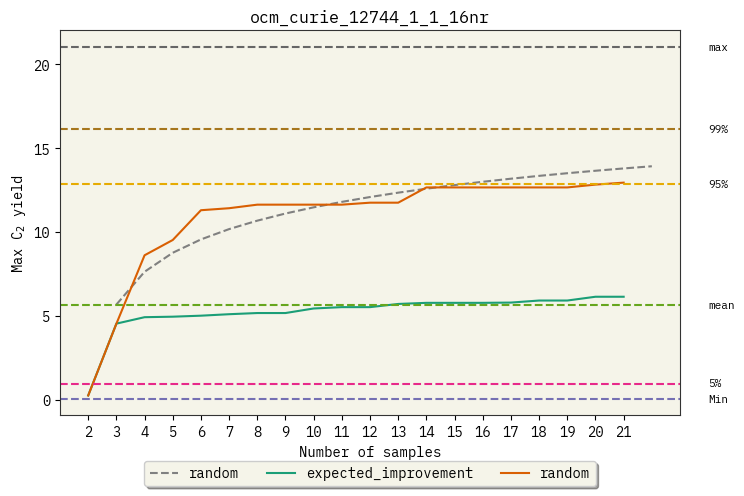

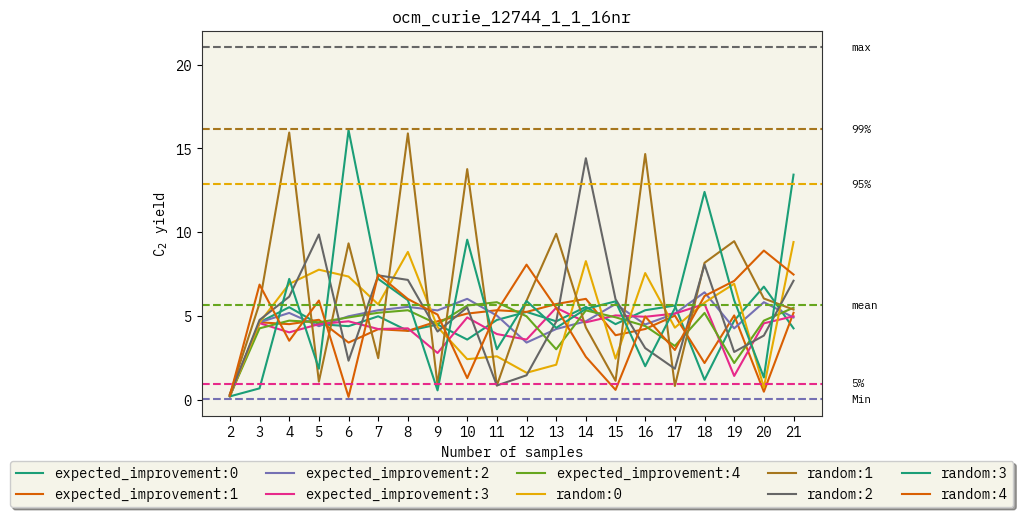

In [26]:
# Quick test
title = f"{path[6:-4]}"
d = cloudpickle.load(open(path, "rb"))
data=raw_data[y_name]
lim=(data.min()-1, data.max()+1)

# name = "LogS"
name = "C$_2$ yield"
# name = "CO STY"

def plot_config():
    plt.title(title)
    plt.axhline(y=data.max(), color="C15", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.quantile(0.99), color="C14", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.quantile(0.99), "99%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.quantile(0.95), color="C13", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.mean(), color="C12", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.quantile(0.05), color="C11", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.quantile(0.05), "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.min(), color="C10", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.min(), "Min", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.ylim(lim)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),
          fancybox=True, shadow=True, ncol=5)

#Debugging plots
# Plot best value on the entire run
plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
# plt.ylabel("Max C$_2$ yield")
plt.ylabel(f"Max {name}")
for acq in d.keys():
    if acq == "random_mean":
        plt.plot(d[acq][0,:,0], d[acq][:, :, 1].astype(float).mean(axis=0), label=f"random", color="gray", linestyle="dashed")
    else:
        # for i in range(M):
        #     plt.plot(d[acq][i,:,1], d[acq][i, :, 2].astype(float), label=f"{acq}:{i}")
        plt.plot(d[acq][0,:,1], d[acq][:, :, 2].astype(float).mean(axis=0), label=acq)
plot_config()
plt.show()

# Plot current values on each iteration
plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
plt.ylabel(f"{name}")
for acq in d.keys():
    if acq == "random_mean":
        continue
    else:
        for i in range(M):
            plt.plot(d[acq][i,:,1], d[acq][i, :, 3].astype(float), label=f"{acq}:{i}")
        # plt.plot(d[acq][0,:,1], d[acq][:, :, 3].astype(float).mean(axis=0), label=f"{acq}")
plot_config()
plt.show()


# BayesOpt Plot

In [44]:
def plot_BO(ax, data_file, title, data, axis_name, lim=None, label=False, M=1):
    d = cloudpickle.load(open(data_file, "rb"))

    for i in range(M):
        if "expected_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['expected_improvement'][i, :, 1]],
            [float(y) for y in d['expected_improvement'][i, :, 2]], 
            color="C1", alpha=0.1
          )
        if "greedy" in d.keys():
           ax.plot(
            [int(s) for s in d['greedy'][i, :, 1]],
            [float(y) for y in d['greedy'][i, :, 2]], 
            color="C2", alpha=0.1
          )
        if "upper_confidence_bound" in d.keys():
          ax.plot(
            [int(s) for s in d['upper_confidence_bound'][i, :, 1]],
            [float(y) for y in d['upper_confidence_bound'][i, :, 2]], 
            color="C3", alpha=0.1
          )
        if "probability_of_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['probability_of_improvement'][i, :, 1]],
            [float(y) for y in d['probability_of_improvement'][i, :, 2]], 
            color="C4", alpha=0.1
          )
        if "random" in d.keys():
          ax.plot(
            [int(s) for s in d['random'][i, :, 1]],
            [float(y) for y in d['random'][i, :, 2]], 
            color="C5", alpha=0.1
          )
    if "expected_improvement" in d.keys():
      label = "EI" if label else None
      ax.plot(
            d['expected_improvement'][:, :, 1].astype('int').mean(axis=0),
            d['expected_improvement'][:, :, 2].astype('float').mean(axis=0), 
            color="C1", label=label
          )
    if "greedy" in d.keys():
      label = "Greedy" if label else None
      ax.plot(
            d['greedy'][:, :, 1].astype('int').mean(axis=0),
            d['greedy'][:, :, 2].astype('float').mean(axis=0), 
            color="C2", label=label
          )
    if "upper_confidence_bound" in d.keys():
      label = "UCB" if label else None
      ax.plot(
            d['upper_confidence_bound'][:, :, 1].astype('int').mean(axis=0),
            d['upper_confidence_bound'][:, :, 2].astype('float').mean(axis=0), 
            color="C3", label=label
          )
    if "probability_of_improvement" in d.keys():
      label = "POI" if label else None
      ax.plot(
            d['probability_of_improvement'][:, :, 1].astype('int').mean(axis=0),
            d['probability_of_improvement'][:, :, 2].astype('float').mean(axis=0), 
            color="C4", label=label
          )
    if "random" in d.keys():
      label = "random" if label else None
      ax.plot(
            d['random'][:,:, 1].astype('int').mean(axis=0),
            d['random'][:,:, 2].astype('float').mean(axis=0), 
            color="C5", label=label
          )
    if "random_mean" in d.keys():
      label = "Random" if label else None
      ax.plot(
            d['random_mean'][:, :, 0].astype('int').mean(axis=0),
            d['random_mean'][:, :, 1].astype('float').mean(axis=0), 
            color="gray", label=label, linestyle="dashed"
      )
    ax.axhline(y=data.max(), color="C15", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.99), color="C14", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.99), "99%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.95), color="C13", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.mean(), color="C12", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
    if not data_file.startswith("./out/sol"):
      ax.axhline(y=data.quantile(0.05), color="C11", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.quantile(0.05)+0.3, "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
      ax.axhline(y=data.min(), color="C10", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.min()-0.3, "min", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.set_title(title)

    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"Measured {axis_name}")
    # ax.set_xticks([i for i in range(0,N+1,5)], [str(x * 1) for x in [i for i in range(0,N+1,5)]])
    if lim:
      ax.set_ylim(lim)
    ax.set_title(title)

### Paper figures

In [60]:
raw_data, starts, indexes, x_name, y_name = get_dataset("ocm", M=0)

Dataset size: 
	12708
Start xs: 
	[]
Start ys: 
	[]
Start indexes: 
	Index([], dtype='int64')



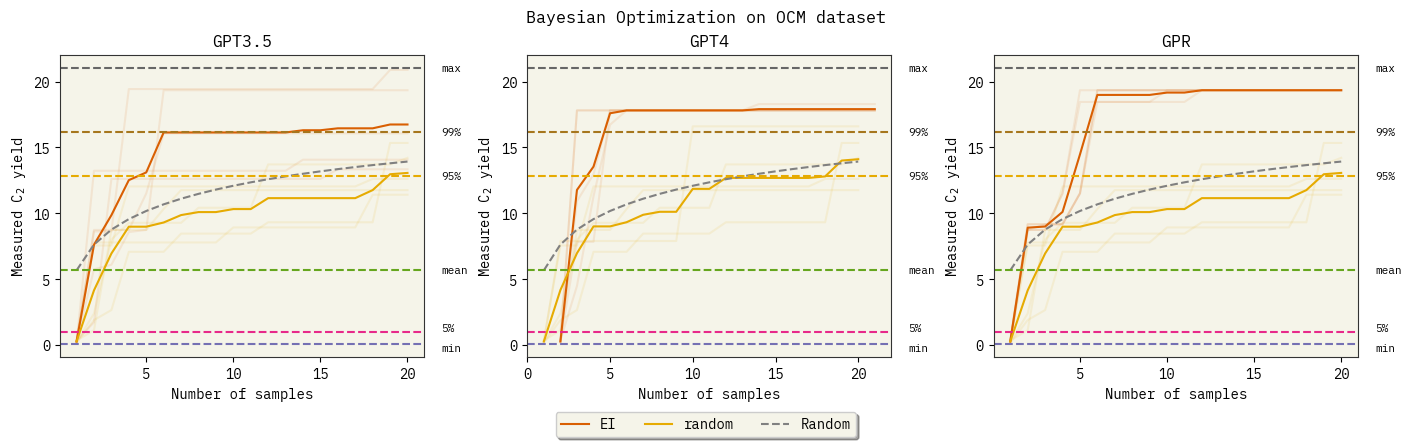

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(raw_data[y_name].min()-1, raw_data[y_name].max()+1)
# plot_BO(axs[0], "./out/ocm_curie_12744_1_1_16nr.pkl","GPT3", 
#          raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)

plot_BO(axs[0], "./out/C2_davinci2_12744_1_16nr.pkl","GPT3.5",
         raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)

plot_BO(axs[1], "./out/ocm_GPT-4_12744_0_s.pkl", "GPT4",
         raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

plot_BO(axs[2], "./out/C2_gpr_12744_1_16nr.pkl", "GPR",
         raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

fig.suptitle("Bayesian Optimization on OCM dataset")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

[6.75 6.02 6.41 5.71 5.82]
Curie is top4979: 6.142
[16.07 20.88 13.34 14.07 19.34]
DaVinci is top91: 16.740000000000002
[18.29 17.81 17.81 17.81 17.81]
Gpt4 is top43: 17.906
[19.34 19.34 19.34 19.34 19.34]
GPR is top10: 19.34


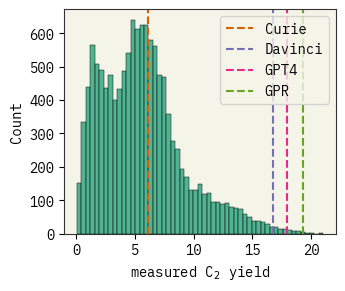

                                                  prompt  completion
737    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       18.60
739    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       17.25
740    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       19.43
744    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       17.16
745    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       21.03
...                                                  ...         ...
11545  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       18.71
11546  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       17.95
11548  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       16.85
11570  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       17.02
11580  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       17.58

[91 rows x 2 columns]


In [62]:
d_curie = cloudpickle.load(open("./out/ocm_curie_12744_1_1_16nr.pkl", "rb"))
d_davinci = cloudpickle.load(open("./out/C2_davinci2_12744_1_16nr.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("./out/ocm_GPT-4_12744_0_s.pkl", "rb"))
d_gpr = cloudpickle.load(open("./out/C2_gpr_12744_1_16nr.pkl", "rb"))

print(d_curie['expected_improvement'][:, -1, 2].astype(float))
best_curie = d_curie['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"Curie is top{np.sum(raw_data[y_name] > best_curie)}: {best_curie}")

print(d_davinci['expected_improvement'][:, -1, 2].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 2].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 2].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_curie, color='C4', linestyle='--', label="Curie")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



In [63]:
raw_data, starts, indexes, x_name, y_name = get_dataset("sol", M=0)

Dataset size: 
	882
Start xs: 
	[]
Start ys: 
	[]
Start indexes: 
	Index([], dtype='int64')



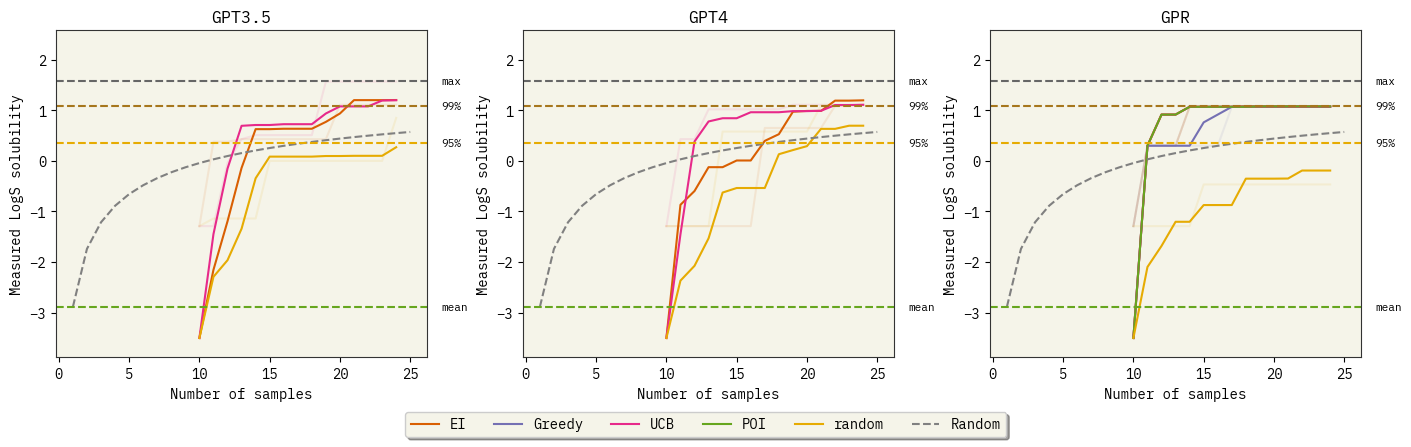

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(1.8)

lim=(raw_data[y_name].mean()-1, raw_data[y_name].max()+1)

plot_BO(axs[0], "./out/sol_davinci_100.pkl", "GPT3.5",
         raw_data[y_name], "LogS solubility", lim, label=False)
plot_BO(axs[1], "./out/sol_gpt4_100.pkl", "GPT4",
         raw_data[y_name], "LogS solubility", lim, label=False)
plot_BO(axs[2], "./out/sol_GPR_100.pkl", "GPR",
         raw_data[y_name], "LogS solubility", lim, label=True)

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_sol", dpi=300, bbox_inches='tight')
plt.show()

[1.11 1.58 1.11 1.11 1.11]
DaVinci is top3: 1.2040000000000002
[1.12 1.58 1.09 1.09 1.11]
Gpt4 is top3: 1.198
[1.07 1.1  1.07 1.07 1.1 ]
GPR is top10: 1.082


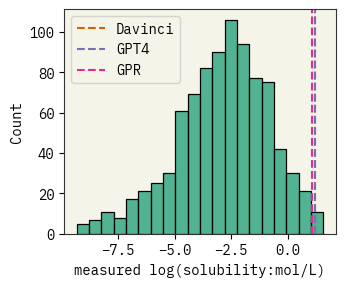

                                                 IUPAC  \
315                                          acetamide   
671                                           methanol   
686                                    methylhydrazine   
923  2-(2-dimethoxyphosphorylsulfanylethylsulfanyl)...   

     measured log(solubility:mol/L)  
315                           1.580  
671                           1.570  
686                           1.340  
923                           1.144  


In [66]:
d_davinci = cloudpickle.load(open("./out/sol_davinci_100.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("./out/sol_gpt4_100.pkl", "rb"))
d_gpr = cloudpickle.load(open("./out/sol_GPR_100.pkl", "rb"))

print(d_davinci['expected_improvement'][:, -1, 2].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 2].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 2].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_sol", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci-0.08])



### C2

In [10]:
np.random.seed(88)

data_path = "./dataset/data/12744_ocm_dataset.csv"
raw_data = pd.read_csv(data_path, sep=";")
# raw_data = raw_data.sample(frac=1).reset_index(drop=True)
# raw_data['completion'] = - raw_data['completion']

x_name = "prompt"
y_name = "completion"

In [15]:
raw_data, starts, indexes, x_name, y_name = get_dataset("ocm", M=5)

Dataset size: 
	12708
Start xs: 
	['To synthesize Al2O3, Al2O3 (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of n.a. (0%), n.a. (0%), n.a. (0%), at 50 ºC for 6 h. Once activated the reaction is ran at 700 ºC. The total flow rate was 15 mL/min (Ar: 10.5 mL/min, CH4: 3.9 mL/min, O2: 0.6 mL/min), leading to a contact time of 0.5 s.', 'To synthesize Na/SiO2, SiO2 (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of n.a. (0%), Na (100%), n.a. (0%), at 50 ºC for 6 h. Once activated the reaction is ran at 700 ºC. The total flow rate was 20 mL/min (Ar: 14.0 mL/min, CH4: 5.1 mL/min, O2: 0.9 mL/min), leading to a contact time of 0.38 s.', 'To synthesize Al2O3, Al2O3 (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of n.a. (0%), n.a. (0%), n.a. (0%), at 50 ºC for 6 h. Once activated the reaction is ran at 700 ºC. The total flow rate was 15 mL/min (Ar: 10.5 mL/min, CH4: 3.6 mL/min, O2: 0.9 mL/min), leading to a contact time of 0.5 s.', 

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,8)
raw_data = pd.read_csv("dataset/data/1180_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_1180_1_tree.pkl","20", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 1180.pkl")

lim=(0,10)
raw_data = pd.read_csv("dataset/data/2950_ocm_dataset.csv", sep=";")
plot_BO(axs[1], "./out/C2_davinci_2950_1_tree.pkl","50",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 2950.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/5900_ocm_dataset.csv", sep=";")
plot_BO(axs[2], "./out/C2_davinci_5900_1_tree.pkl", "100",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 5900.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[3], "./out/C2_davinci_12744_1_tree_2.pkl", "216",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

fig.suptitle("TreePool with davinci")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    './out/C2_davinci_1180_1_tree.pkl',
    './out/C2_davinci_2950_1_tree.pkl',
    './out/C2_davinci_5900_1_tree.pkl',
    './out/C2_davinci_12744_1_tree.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for run in d['upper_confidence_bound'][:, :, 0]:
        print([r[14:r.find(",")] for r in run])
    
    print()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,8)
raw_data = pd.read_csv("dataset/data/1180_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_1180_1_16hh.pkl","20", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 1180.pkl")

lim=(0,10)
raw_data = pd.read_csv("dataset/data/2950_ocm_dataset.csv", sep=";")
plot_BO(axs[1], "./out/C2_davinci_2950_1_16hh.pkl","50",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 2950.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/5900_ocm_dataset.csv", sep=";")
plot_BO(axs[2], "./out/C2_davinci_5900_1_16hh.pkl", "100",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 5900.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[3], "./out/C2_davinci_12744_1_16hh.pkl", "216",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")
         

fig.suptitle("Subpool of 16 with half random samples with davinci")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    './out/C2_davinci_1180_1_16hh.pkl',
    './out/C2_davinci_2950_1_16hh.pkl',
    './out/C2_davinci_5900_1_16hh.pkl',
    './out/C2_davinci_12744_1_16hh.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for run in d['upper_confidence_bound'][:, :, 0]:
        print([r[14:r.find(",")] for r in run])
    
    print()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_fulldataset_new_subpool_16_allrandom_1init.pkl","all_random",
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[1], "./out/C2_davinci_12744_1_16hh.pkl","half_random",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[2], "./out/C2_davinci_fulldataset_subpool_16_no_random_1_init.pkl", "no_random",
# plot_BO(axs[2], "./out/C2_davinci_fulldataset_subpool_16_no_random_newest_seed0_2_init.pkl", "no_random",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[3], "./out/C2_davinci_12744_1_tree_2.pkl", "TreePool",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")
         

fig.suptitle("216 samples with each subpool")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    # './out/C2_davinci_fulldataset_new_subpool_16_allrandom_1init.pkl',
    # './out/C2_davinci_12744_1_16hh.pkl',
    # './out/C2_davinci_fulldataset_subpool_16_no_random_1_init.pkl',
    './out/C2_davinci_fulldataset_subpool_16_no_random_newest_seed0_2_init.pkl',
    # './out/C2_davinci_12744_1_tree.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for k in d.keys():
        for run in d[k][:, :, 0]:
            print(k, [r[14:r.find(",")] for r in run])
    
    print()

In [ ]:
d_davinci = cloudpickle.load(open("paper/out/C2_davinci_100.pkl", "rb"))
print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

d_gpt4 = cloudpickle.load(open("paper/out/C2_GPT4_100.pkl", "rb"))
print(d_gpt4['upper_confidence_bound'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

d_gpr = cloudpickle.load(open("paper/out/C2_GPR_100.pkl", "rb"))
print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



### iupac-sol

In [ ]:
np.random.seed(0)
data_path = "paper/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)
raw_data = raw_data.dropna()
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# raw_data['measured log(solubility:mol/L)'] = -raw_data['measured log(solubility:mol/L)']
x_name = "IUPAC"
y_name = "measured log(solubility:mol/L)"

In [27]:
raw_data, starts, indexes, x_name, y_name = get_dataset("sol", M=5)

Dataset size: 
	882
Start xs: 
	['(4-bromo-2,5-dichlorophenoxy)-dimethoxy-sulfanylidene-lambda5-phosphane', 'ethoxy-ethyl-sulfanylidene-(2,4,5-trichlorophenoxy)-lambda5-phosphane', 'hexadecane', 'tetradecane', '(2,5-dioxo-4,4-diphenylimidazolidin-1-yl)methyl heptanoate']
Start ys: 
	[-6.09, -5.752, -8.4, -7.96, -6.301]
Start indexes: 
	Index([385, 914, 612, 887, 246], dtype='int64')



In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1.8)

lim=(-5.5,2)

plot_BO(axs[0], "paper/out/sol_davinci_100.pkl", "Topk - davinci",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[1], "paper/out/sol_gpt4_100.pkl", "Topk - GPT-4",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[2], "paper/out/sol_GPR_100.pkl", "GPR",
         raw_data[y_name], "LogS solubility", lim, label=True, data_file_random="paper/out/sol - random.pkl")

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_sol", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
d_davinci = cloudpickle.load(open("paper/out/sol_davinci_100.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("paper/out/sol_gpt4_100.pkl", "rb"))
d_gpr = cloudpickle.load(open("paper/out/sol_GPR_100.pkl", "rb"))

print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_sol", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci-0.08])



FileNotFoundError: [Errno 2] No such file or directory: 'paper/out/sol_davinci_100.pkl'